In [1]:
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import glob as glob
import gzip
import shutil
from  tqdm import tqdm
import xarray as xr

import numpy as np
from scipy import interpolate

import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from geodatasets import get_path
import numpy as np
import xarray as xr

import sys
sys.path.append('..')
from scripts.dicts import *
from scripts.great_circle_distance import great_circle_distance
from scripts.paths import *





Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


In [2]:
path_BasalMelt = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/Karlsson2021_basalmelt/basalmelt.nc'

In [3]:

fpath_adj_sect  = pathDataGithub +'temp/adjusted_section_numbers_slater.nc'
fpath_masks1k = pathDataGithub + 'temp/masks1k.nc'
folder_MARRACMO1km = pathDataGithub + "raw/liquid/"

ds_adj_sect = xr.open_dataset(fpath_adj_sect)
ds_masks1k = xr.open_dataset(fpath_masks1k)


In [4]:
ds_Basal = xr.open_dataset(path_BasalMelt)


In [5]:
lats_target = ds_Basal['latitude'].values
lons_target = ds_Basal['longitude'].values

lats_source = ds_masks1k.LAT.values
lons_source = ds_masks1k.LON.values

values_source = ds_adj_sect['section_numbers_adjusted'].values

lats_target.shape, lons_target.shape, lats_source.shape, lons_source.shape, values_source.shape

adj_sect_basal = interpolate.griddata((lats_source.flatten(), lons_source.flatten()), values_source.flatten(),
                                (lats_target, lons_target),
                                method='nearest')
                                

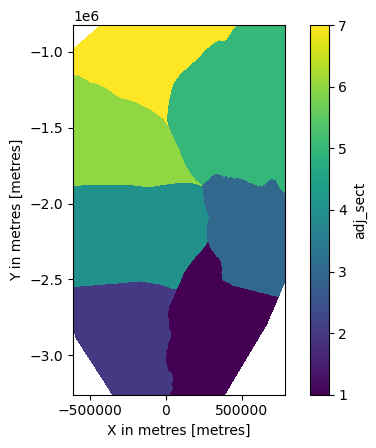

In [6]:
plt.imshow(np.reshape(adj_sect_basal, lats_target.shape))

ds_Basal['adj_sect'] = xr.DataArray(adj_sect_basal, dims=['y','x'], coords={'y': ds_Basal.y, 'x': ds_Basal.x})
ds_Basal['adj_sect'].plot()

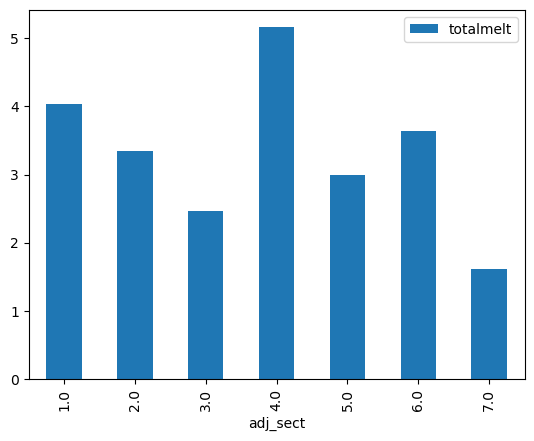

In [7]:
df_total_melt_per_basin = ds_Basal['totalmelt'].groupby(ds_Basal['adj_sect']).sum().to_dataframe() /1e3
df_total_melt_per_basin.plot(kind='bar')

df_total_melt_per_basin.round(1)

df_melt_per_basin = df_total_melt_per_basin.copy()

Also for individual components

In [8]:
ds_Basal

<xarray.Dataset> Size: 355MB
Dimensions:            (y: 2437, x: 1400, crs: 1)
Coordinates:
  * y                  (y) float64 19kB -3.26e+06 -3.259e+06 ... -8.238e+05
  * x                  (x) float64 11kB -6.109e+05 -6.099e+05 ... 7.881e+05
  * crs                (crs) object 8B '+init=epsg:3413'
Data variables: (12/13)
    latitude           (y, x) float64 27MB 60.06 60.06 60.06 ... 79.51 79.5
    longitude          (y, x) float64 27MB -55.61 -55.6 -55.58 ... -1.304 -1.267
    gfmelt             (y, x) float64 27MB ...
    fricmelt           (y, x) float64 27MB ...
    vhdmelt            (y, x) float64 27MB ...
    totalmelt          (y, x) float64 27MB nan nan nan nan ... nan nan nan nan
    ...                 ...
    gfmelt_upper_unc   (y, x) float64 27MB ...
    fricmelt_unc       (y, x) float64 27MB ...
    vhdmelt_unc        (y, x) float64 27MB ...
    totmelt_lower_unc  (y, x) float64 27MB ...
    totmelt_upper_unc  (y, x) float64 27MB ...
    adj_sect           (y, x) float64 27MB nan nan nan nan ... 5.0 5.0 5.0 5.0
Attributes:
    description:  Basal melt
    title:        Greenland basal melt
    institution:  Geological Survey of Denmark and Greenland
    source:       https://www.promice.org/PromiceDataPortal/
    reference:    https://eartharxiv.org/repository/view/151/

In [9]:
for melt_type in ['gfmelt', 'fricmelt', 'vhdmelt']:
    df_melt_per_basin[melt_type] = ds_Basal[melt_type].groupby(ds_Basal['adj_sect']).sum().to_dataframe() /1e3
df_melt_per_basin


,totalmelt,gfmelt,fricmelt,vhdmelt
adj_sect,,,,
1.0,4.038103,0.716053,2.406592,0.915458
2.0,3.341879,0.980276,1.150804,1.210799
3.0,2.462798,0.560329,1.310317,0.592153
4.0,5.153129,1.087371,2.911703,1.154055
5.0,2.991133,1.375868,1.102951,0.512314
6.0,3.642482,0.573090,2.194981,0.874410
7.0,1.613679,0.482080,0.690820,0.440779


# Other way around

In [10]:
lats_source = ds_Basal['latitude'].values
lons_source = ds_Basal['longitude'].values
values_source = ds_Basal['totalmelt'].values

lats_target = ds_masks1k.LAT.values
lons_target = ds_masks1k.LON.values

melt_basal = interpolate.griddata((lats_source.flatten(), lons_source.flatten()), values_source.flatten(),
                                (lats_target, lons_target), 
                                method='nearest')
melt_basal = np.reshape(melt_basal, lats_target.shape)
melt_basal = xr.DataArray(melt_basal, dims=['y','x'], coords={'y': ds_adj_sect.y, 'x': ds_adj_sect.x})


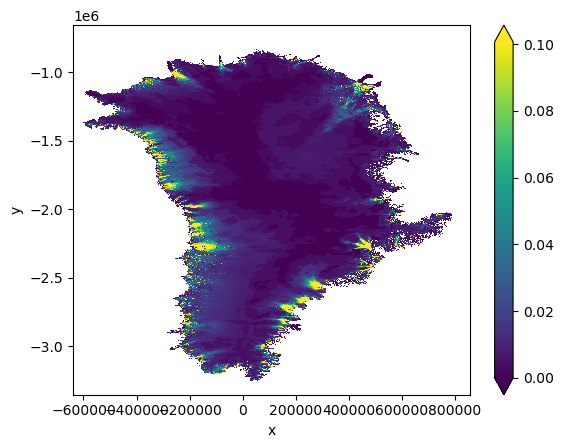

In [11]:
melt_basal.plot(robust=True)




Sum is 23.3 km3/yr


,Total melt (m/yr)
section_numbers_adjusted,
1.0,4.0
2.0,3.3
3.0,2.5
4.0,5.2
5.0,3.0
6.0,3.6
7.0,1.6


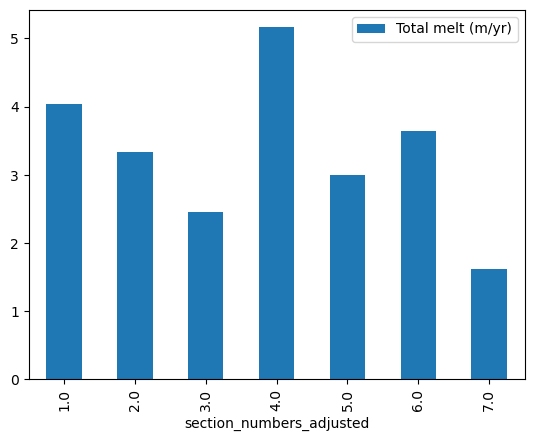

In [12]:
df_melt_basal_per_basin_racmo_grid = melt_basal.groupby(ds_adj_sect['section_numbers_adjusted']).sum().to_dataframe(name='Total melt (m/yr)') /1e3
df_melt_basal_per_basin_racmo_grid.plot(kind='bar')
print(f"Sum is {df_melt_basal_per_basin_racmo_grid.sum().values[0]:.1f} km3/yr")
df_melt_basal_per_basin_racmo_grid.round(1)


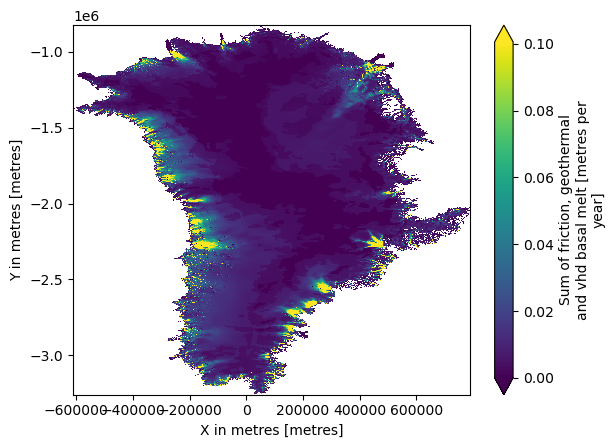

In [13]:
ds_Basal['totalmelt'].plot(robust=True)

In [14]:
df_monthly_fluxes = pd.read_csv('/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/processed/Seasonal_Greenland_2009_2022.csv', index_col=0)
df_monthly_fraction_runoff_of_total_runoff = (df_monthly_fluxes/ df_monthly_fluxes.sum(axis=0))['Liquid Runoff Ice Sheet']

In [15]:
folder = '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/processed/Seasonal cycle per sector/'
files = glob.glob(folder + '*.csv')

df_basin_monthly_runoff = pd.DataFrame()
for f in files:
    df = pd.read_csv(f, index_col=0)['Liquid Runoff Ice Sheet'].rename(f.split('/')[-1].split('_')[0])
    df_basin_monthly_runoff = pd.concat([df_basin_monthly_runoff, df], axis=1)
df_basin_monthly_runoff_fraction = df_basin_monthly_runoff / df_basin_monthly_runoff.sum(axis=0)
df_basin_monthly_runoff_fraction

,NE,CW,CE,NO,NW,SE,SW
1,0.002027,0.000212,0.006122,0.000454,0.000522,0.013388,0.003899
2,0.001947,0.000203,0.005581,0.000373,0.000446,0.011931,0.003928
3,0.002428,0.000251,0.006594,0.000408,0.000491,0.013320,0.004239
4,0.008173,0.004184,0.013982,0.000875,0.000642,0.019363,0.007020
5,0.033773,0.060957,0.048621,0.003630,0.004905,0.046979,0.047066
6,0.203600,0.230540,0.200243,0.227205,0.185149,0.161125,0.188219
7,0.366219,0.328951,0.294229,0.394381,0.415901,0.277727,0.269337
8,0.313880,0.273284,0.267055,0.340590,0.335646,0.270292,0.263849
9,0.059844,0.094692,0.123545,0.030286,0.053992,0.129623,0.171888
10,0.003772,0.005950,0.019248,0.000749,0.001165,0.026813,0.025944


In [16]:
df_melt_per_basin

,totalmelt,gfmelt,fricmelt,vhdmelt
adj_sect,,,,
1.0,4.038103,0.716053,2.406592,0.915458
2.0,3.341879,0.980276,1.150804,1.210799
3.0,2.462798,0.560329,1.310317,0.592153
4.0,5.153129,1.087371,2.911703,1.154055
5.0,2.991133,1.375868,1.102951,0.512314
6.0,3.642482,0.573090,2.194981,0.874410
7.0,1.613679,0.482080,0.690820,0.440779


<Axes: >

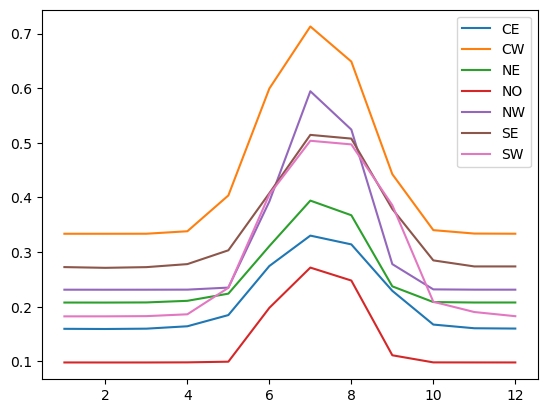

In [17]:
df_vhd_monthly_basin = (df_melt_per_basin.rename(index=dict_sections)['vhdmelt'] * df_basin_monthly_runoff_fraction)
monthly_equal = pd.DataFrame(index=df_basin_monthly_runoff_fraction.index, columns = df_basin_monthly_runoff_fraction.columns,data =1/12)
df_gf_monthly_basin = (df_melt_per_basin.rename(index=dict_sections)['gfmelt'] * monthly_equal)
df_fric_monthly_basin = (df_melt_per_basin.rename(index=dict_sections)['fricmelt'] * monthly_equal)
df_total_monthly = df_vhd_monthly_basin + df_gf_monthly_basin + df_fric_monthly_basin
df_total_monthly.plot()

In [18]:
df_vhd_monthly_basin.sum()

CE    0.592153
CW    1.154055
NE    0.512314
NO    0.440779
NW    0.874410
SE    0.915458
SW    1.210799
dtype: float64

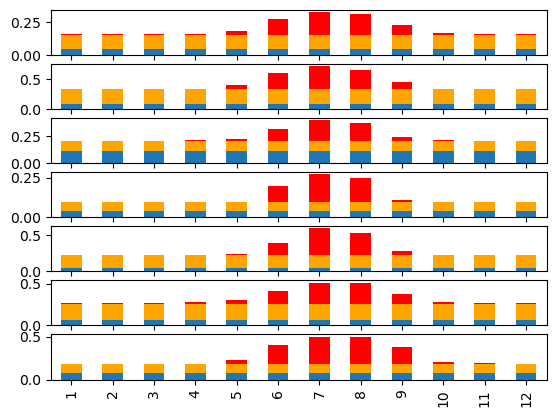

In [19]:


fig, axs = plt.subplots(7,1)
for basin in df_total_monthly.columns:
    ax = axs.flatten()[list(df_total_monthly.columns).index(basin)]
    df_gf_monthly_basin[basin].plot.bar(ax=ax)
    df_fric_monthly_basin[basin].plot.bar(ax=ax, bottom=df_gf_monthly_basin[basin], color='orange')
    df_vhd_monthly_basin[basin].plot.bar(ax=ax, bottom=df_gf_monthly_basin[basin] + df_fric_monthly_basin[basin], color='red')


<Axes: xlabel='adj_sect'>

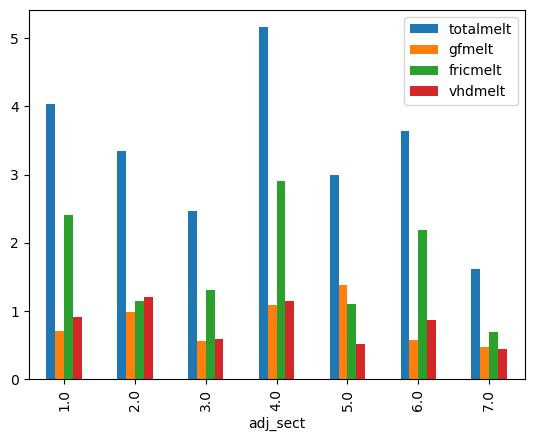

In [272]:
df_melt_per_basin.plot.bar()

Sum is 23.3 km3/yr


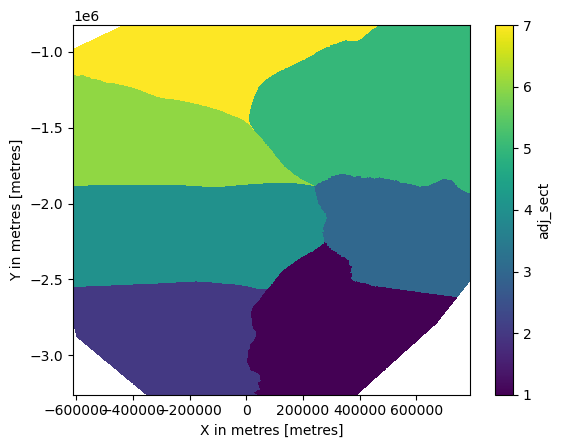

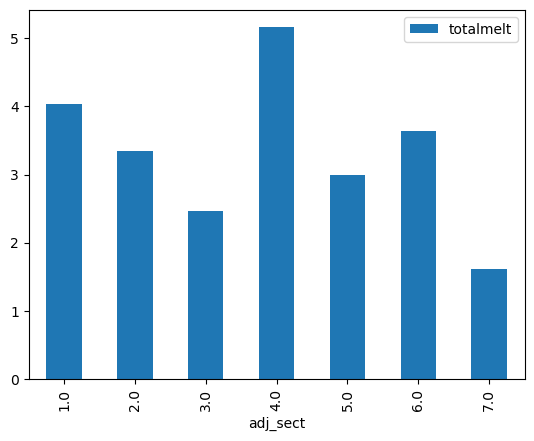

In [21]:
from Karlsson2021_Basal_Melt import *

In [22]:
ds_Basal['totalmelt'].sum().values/1e3

23.243202149145215

In [30]:
df_Basal_basin_monthly = df_vhd_monthly_basin + df_gf_monthly_basin + df_fric_monthly_basin
df_Basal_GrIS_monthly = df_Basal_basin_monthly.sum(axis=1)
df_Basal_GrIS_monthly

1     1.484478
2     1.482705
3     1.485311
4     1.506404
5     1.684261
6     2.588314
7     3.321275
8     3.106790
9     2.062379
10    1.539441
11    1.495166
12    1.486679
dtype: float64